# Implied volatility

The example '04_BlackScholesPricer_example.ipynb' introduces how the implementation of Black-Scholes pricing formula can be used in option pricing. To do this two parameters need to be provided for the model - the risk-free rate and the volatility. However, often the price of the option is not an unknown as the options are traded on the markets with known bids and asks. The problem is then to choose proper parameters that match the observed prices.

Since the risk-free rate is known with certainty, the only parameter that can be tweaked is the volatility. So instead of approximating it from historical data (see example '...') it can be chosen so that the observed and model prices match. This volatility is known as the _option implied volatility_. 

In [1]:
# Setup for the notebook
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt

plt.style.use('ggplot')

from quantform.pylib import QfDate
from quantform.pylib.equity.utils import parse_option_id, form_option_id
from quantform.pylib.equity.derivative import Option
from quantform.pylib.surface import ImpliedVolatilitySurface
from quantform.pylib.curve import ImpliedVolatilityCurve

ImpliedVolatilitySurface

quantform.pylib.surface.ImpliedVolatilitySurface.ImpliedVolatilitySurface

In [2]:
project_root = Path(os.path.abspath(""))

report_date = QfDate(2025, 8, 15)

# The used risk-free rate is the yield of a two year US Treasury quoted EOD 2025-08-15
risk_free_rate = 0.03755

# The value of the underlying is also quoted EOD 2025-08-15. Use a slightly smaller value so that the implied vol can be
# calculated. This is required as the bids and asks might not be up to date
underlying_value = 630  # Actual 643.44 USD

# Read the market data from a CSV file. The market data covers the option prices quoted EOD 2025-08-15 for all available SPY options
option_df = pd.read_csv(project_root / "example_data" / "SPY_Calls_2025-08-15.tsv", sep='\t')

# Function that creates an Option object from the given option price data. If the implied volatility cannot be calculated skips the option
def to_option(row: pd.Series) -> Option:
  try:
    return Option(row["Contract Name"], *parse_option_id(row["Contract Name"]), risk_free_rate=risk_free_rate, 
                  market_price=(row["Bid"] + row["Ask"]) / 2, underlying_value=underlying_value, report_date=report_date)
  except AssertionError as e:
     print(f"Not able to calculate the implied volatility for option {row["Contract Name"]}! ({e})")
         
# Note that calculating the implied volatilities for thousands of options is quite computationally expensive.
# However, as going forward the same underlying value and report date will be used, it is enough to do this just once
options = [to_option(row) for _, row in option_df.iterrows()]
options = [option for option in options if option is not None]

Not able to calculate the implied volatility for option SPY250829C00335000! (Implied volatility can't be calculated as the lower bound difference is not negative! (Lower bound is 38.708804865590025))
Not able to calculate the implied volatility for option SPY250829C00340000! (Implied volatility can't be calculated as the lower bound difference is not negative! (Lower bound is 62.16624971433012))
Not able to calculate the implied volatility for option SPY250829C00350000! (Implied volatility can't be calculated as the lower bound difference is not negative! (Lower bound is 61.96113941181045))
Not able to calculate the implied volatility for option SPY250829C00355000! (Implied volatility can't be calculated as the lower bound difference is not negative! (Lower bound is 32.15858426055058))
Not able to calculate the implied volatility for option SPY250829C00365000! (Implied volatility can't be calculated as the lower bound difference is not negative! (Lower bound is 6.953473958030827))
Not 

## ImpliedVolatilityCurve

The implied volatility was already calculated for a single option in the example '04_BlackScholesPricer_example.ipynb'. However, for options maturing on the same date a single value for volatility is rarely enough to explain the prices of all options. Thus, the implied volatility should be calculated for each option and interpolated between the available strikes. This can be done using the ImpliedVolatilityCurve object, which inherits most of it's functionality from the GenericCurve class introduced in example '02_curve_example.ipynb'.

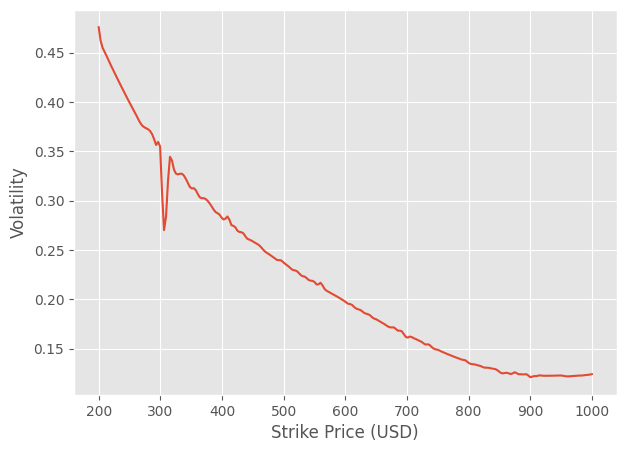

In [3]:
# Options with long time to maturity
curve_date = QfDate(2027, 12, 17)
curve_options = [option for option in options if option.maturity_date == curve_date]

curve = ImpliedVolatilityCurve(curve_options, underlying_value, report_date)
fig = curve.plot(250)

plt.xlabel("Strike Price (USD)")
plt.ylabel("Volatility")
plt.show()

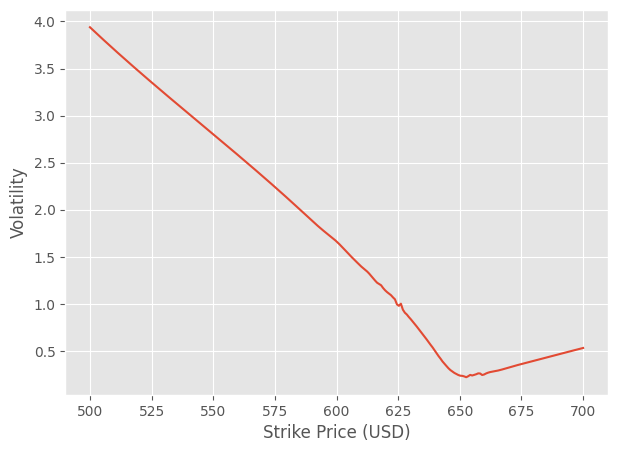

In [4]:
# Options with very short time to maturity
curve_date = QfDate(2025, 8, 18)
curve_options = [option for option in options if option.maturity_date == curve_date]

curve = ImpliedVolatilityCurve(curve_options, underlying_value, report_date)
fig = curve.plot(250)

plt.xlabel("Strike Price (USD)")
plt.ylabel("Volatility")
plt.show()

## ImpliedVolatilitySurface

Instead of calculating the implied volatilities for options with just a single maturity date, they can be calculated for all available options and interpolated for the rest to form an implied volatility surface.

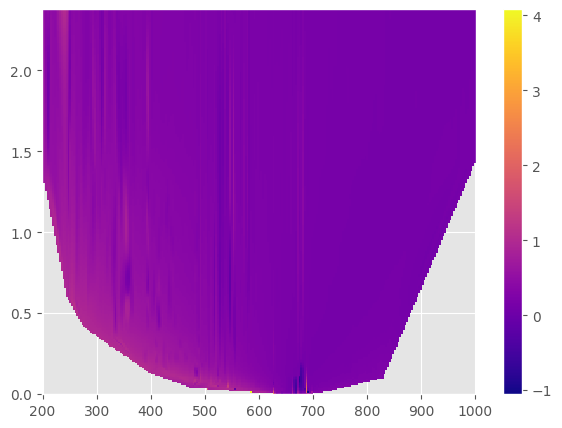

In [5]:
# Some options can have unreasonable volatilities due to poor price data. 
# Ignore these so that the surface is visible
valid_options = [option for option in options if (option.pricer.volatility > -1) and (option.pricer.volatility < 1)]

surf = ImpliedVolatilitySurface(valid_options, underlying_value, report_date)
fig = surf.plot((250, 250), cmap_name='plasma')

plt.show()

While somewhat hard to read the volatility surface does show a smile similar to that of the curve where the ITM options have higher implied volatility than ATM or OTM options. This effect is most apparent for the options maturing soon. 